# Grammar Error Correction - Local Setup

**Modified for local execution with GPU support**

### Directory Structure:
```
GrammarErrorCorrection_Local/
├── GEC/
│   ├── data/                  # Dataset files
│   ├── embeddings/            # FastText embeddings
│   ├── models/
│   │   └── ENC_DEC_EMB/       # Model weights
│   └── notebook.ipynb
```

### Prerequisites:
1. Run `pip install -r requirements.txt` before starting
2. Place `lang8.bea19.tar.gz` in the `data/` folder
3. Ensure GPU drivers (CUDA/cuDNN) are installed for TensorFlow GPU support

# Grammatical Error Correction
1 - Data Pre-processing

In [1]:
# Local Setup - Define paths and check GPU
import os
import subprocess
import shutil

# Get the directory where this notebook is located
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
if not NOTEBOOK_DIR or NOTEBOOK_DIR == ".":
    NOTEBOOK_DIR = os.getcwd()

# Define local paths
DATA_DIR = os.path.join(NOTEBOOK_DIR, "data")
EMBEDDINGS_DIR = os.path.join(NOTEBOOK_DIR, "embeddings")
MODELS_DIR = os.path.join(NOTEBOOK_DIR, "models")
ENC_DEC_EMB_DIR = os.path.join(MODELS_DIR, "ENC_DEC_EMB")

# Create directories if they don't exist
for dir_path in [DATA_DIR, EMBEDDINGS_DIR, MODELS_DIR, ENC_DEC_EMB_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Path to your Downloads folder (update if different)
DOWNLOADS_DIR = os.path.expanduser("~/Downloads")

print(f"Notebook Directory: {NOTEBOOK_DIR}")
print(f"Data Directory: {DATA_DIR}")
print(f"Embeddings Directory: {EMBEDDINGS_DIR}")
print(f"Models Directory: {MODELS_DIR}")

# Check for GPU availability (TensorFlow will be imported later)
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"\n✅ GPU Available: {len(gpus)} GPU(s) detected")
        for gpu in gpus:
            print(f"   - {gpu}")
        # Enable memory growth to prevent TF from allocating all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("\n⚠️ No GPU detected. Training will be slower on CPU.")
except ImportError:
    print("TensorFlow not installed yet. GPU check will happen after installation.")

Notebook Directory: /Users/abhishekgupta/Documents/Career/Learnings/Machine-Learning/Projects/GrammarErrorCorrection_Local/GEC
Data Directory: /Users/abhishekgupta/Documents/Career/Learnings/Machine-Learning/Projects/GrammarErrorCorrection_Local/GEC/data
Embeddings Directory: /Users/abhishekgupta/Documents/Career/Learnings/Machine-Learning/Projects/GrammarErrorCorrection_Local/GEC/embeddings
Models Directory: /Users/abhishekgupta/Documents/Career/Learnings/Machine-Learning/Projects/GrammarErrorCorrection_Local/GEC/models
TensorFlow not installed yet. GPU check will happen after installation.


In [2]:
# Dependencies should be installed via requirements.txt
# Run in terminal: pip install -r requirements.txt
# 
# If wordcloud is not installed, uncomment and run:
# import subprocess
# subprocess.run(["pip", "install", "wordcloud"], check=True)

In [3]:
#Import Necessary Librarires
import re
import unicodedata
import spacy
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'spacy'

In [ ]:
# Extract the tar file from Downloads folder to data directory
import tarfile

# Source: Your Downloads folder
tar_source = os.path.join(DOWNLOADS_DIR, "lang8.bea19.tar.gz")

# Check if already extracted
m2_file_path = os.path.join(DATA_DIR, "lang8.train.auto.bea19.m2")

if os.path.exists(m2_file_path):
    print("Dataset already extracted!")
else:
    if os.path.exists(tar_source):
        print(f"Extracting {tar_source} to {DATA_DIR}...")
        with tarfile.open(tar_source, "r:gz") as tar:
            tar.extractall(path=DATA_DIR)
        print("Extraction complete!")
    else:
        raise FileNotFoundError(f"Please place 'lang8.bea19.tar.gz' in {DOWNLOADS_DIR}")

# List extracted files
for f in os.listdir(DATA_DIR):
    print(f)

lang8.train.auto.bea19.m2
lang8_to_m2.py
readme.txt


In [ ]:
with open(os.path.join(DATA_DIR, 'lang8.train.auto.bea19.m2')) as f:
    data = f.readlines()

In [6]:
print("number of lines in data")
print(len(data))

number of lines in data
4015882


In [ ]:
m2 = open(os.path.join(DATA_DIR, 'lang8.train.auto.bea19.m2')).read().strip().split("\n\n")
out = open(os.path.join(DATA_DIR, 'corrected.txt'), "w")
in_ = open(os.path.join(DATA_DIR, 'error.txt'), "w")
# Do not apply edits with these error types
skip = {"noop", "UNK", "Um"}

for sent in tqdm(m2):
    #print(sent)
    sent = sent.split("\n")
    cor_sent = sent[0].split()[1:] # Ignore "S "

    in_.write(" ".join(sent[0].split()[1:])+"\n" )
    #print('ORIGINAL',sent[0].split()[1:])

    edits = sent[1:]
    offset = 0
    for edit in edits:
        edit = edit.split("|||")
        if len(edit) < 2:
            continue
        if edit[1] in skip: continue # Ignore certain edits
        coder = int(edit[-1])
        if coder != 0: continue # Ignore other coders
        span = edit[0].split()[1:] # Ignore "A "
        start = int(span[0])
        end = int(span[1])
        cor = edit[2].split()
        cor_sent[start+offset:end+offset] = cor
        offset = offset-(end-start)+len(cor)

    #print('CORRECT',cor_sent)
    out.write(" ".join(cor_sent)+"\n")

out.close()
in_.close()

100%|██████████| 1037561/1037561 [00:04<00:00, 224615.21it/s]


In [ ]:
with open(os.path.join(DATA_DIR, 'corrected.txt')) as f:
    correct_data = f.read()

with open(os.path.join(DATA_DIR, 'error.txt')) as f:
    error_data = f.read()

In [9]:
correct_sentences = correct_data.split('\n')
error_sentences = error_data.split('\n')

min_len = min(len(correct_sentences), len(error_sentences))

final_data = pd.DataFrame({
    'correct': correct_sentences[:min_len],
    'error': error_sentences[:min_len]
})

In [10]:
final_data.describe()

,correct,error
count,1037543,1037543
unique,937945,943943
top,URL,URL
freq,2762,2765


In [11]:
pd.options.display.max_colwidth = 600
final_data[:50]

,correct,error
0,Good luck on your new start !,Good luck on your new start !
1,My teacher is going to move to change his job .,My teacher is going to move to change his job .
2,He is a so nice guy and taught me English very kindly and was willing to accept my getting off the track .,He is a so nice guy and taught me English very kindly and was willing to accept my getting off the track .
3,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .
4,"Actually , he was the one who let me know about Lang - 8 . .","Actually , who let me know about Lang - 8 was him ."
5,He is also good at Japanese and studies ' Kanji ' .,He is also good at Japanese and studies ' Kanji ' .
6,His Kanji ability is much better than mine .,His Kanji 's ability is much better than me .
7,"We 've known each other for only half a year , but his lessons were a lot of fun .","We 've known each other for only half a year , but his lesson was a lot of fun ."
8,I 'm going to miss him but I really wish him the best of luck with his new life .,I 'm going to miss him but I really wish him the best of luck with his new life .
9,I 'm looking forward to seeing him again through here .,I 'm looking forward to seeing him again through here .


In [ ]:
final_data.to_csv(os.path.join(DATA_DIR, "raw_data.csv"), index=False)


In [ ]:
final_data.to_csv(os.path.join(DATA_DIR, "raw_data.csv"), index=False)


In [14]:
final_data.describe()

,correct,error
count,1037543,1037543
unique,937945,943943
top,URL,URL
freq,2762,2765


In [15]:
final_data = final_data.drop_duplicates()

In [16]:
final_data.describe()

,correct,error
count,950730,950730
unique,937945,943943
top,Thank you for reading .,Nice to meet you .
freq,31,11


In [17]:
final_data = final_data.dropna()

In [18]:
final_data.describe()

,correct,error
count,950730,950730
unique,937945,943943
top,Thank you for reading .,Nice to meet you .
freq,31,11


In [19]:
len_1 = [ len(final_data['correct'].iloc[i]) for i in range(len(final_data['correct'])) ]
len_2= [ len(final_data['error'].iloc[i]) for i in range(len(final_data['error'])) ]

Text(0.5, 0, 'Number of words in the grammatically correct sentences')

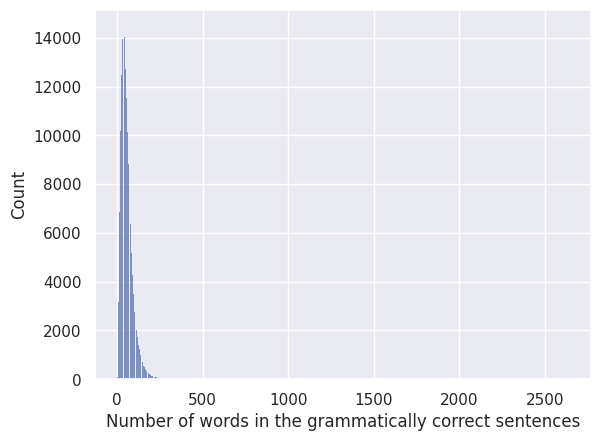

In [20]:
sns.set_theme()
ax = sns.histplot(data=len_1)
ax.set_xlabel('Number of words in the grammatically correct sentences')

Text(0.5, 0, 'Number of words in the grammatically incorrect sentences')

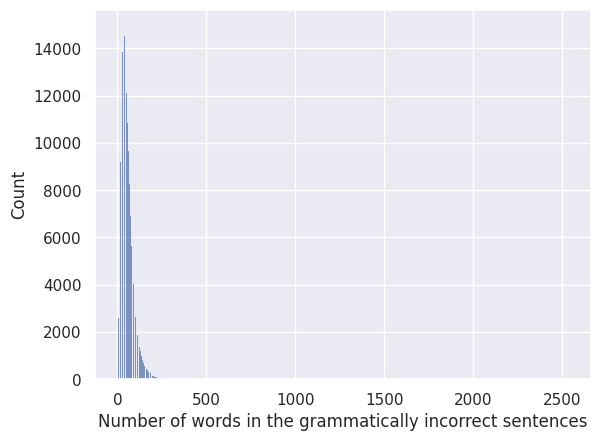

In [21]:
sns.set_theme()
ax = sns.histplot(data=len_2)
ax.set_xlabel('Number of words in the grammatically incorrect sentences')

In [22]:
for i in range(0, 100, 10):
  print(np.percentile(len_1,i))

1.0
20.0
28.0
35.0
41.0
48.0
56.0
66.0
79.0
101.0


In [23]:
for i in range(0, 100, 10):
  print(np.percentile(len_2,i))

0.0
19.0
27.0
34.0
40.0
47.0
55.0
64.0
77.0
100.0


Remove sentences that:

have less than equal to 5 words
have more than or equal to 30 words
have the same error sentence and correct sentence


In [24]:
for i, row in enumerate(final_data['error']):
  #print(i, row)
  if row.split(" ") == final_data['correct'].iloc[i].split(" ") or len(row.split(" ")) >= 15 or len(row.split(" ")) <= 5:
    final_data.iloc[i] = np.nan

In [25]:
final_data = final_data.dropna()

In [26]:


final_data.describe()

,correct,error
count,290258,290258
unique,288195,289550
top,This is my first diary entry .,I start Lang - 8 today .
freq,20,5


In [27]:
final_data

,correct,error
3,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .
4,"Actually , he was the one who let me know about Lang - 8 . .","Actually , who let me know about Lang - 8 was him ."
6,His Kanji ability is much better than mine .,His Kanji 's ability is much better than me .
11,I heard a sentence last night when I was watching TV .,I heard a sentence last night when I watched TV .
15,"When you go uphill , you have to bend your back .","When you go uphill , you hvae to bend your back ."
...,...,...
1037527,I have just come up with an idea .,I just come up with an idea .
1037528,My journals should be written in an organized way .,If the essay should me written in an organized way .
1037530,Sometimes I think I have a problem in using prepositions .,Sometimes I think I have problem in using prep .
1037536,I think it is a perfect word for describing my day yesterday .,I think it is a perfect word for expressing my yesterday .


In [28]:
#check for missing values
final_data.isna().any()

,0
correct,False
error,False


Basic preprocessing :

- Decontractions like do n't, I 'm,
- Handle : D, x D etc
- Remove brackets, remove text within it : "And I think it 's fun , right ?" "And I think it 's fun , right ? ( YEAH ! )"
Note: There is noise in the data and use of speacial characters.

ALSO BIG NOTE:

- Remove missing, duplicate values.
- Experiment w keeping same sentences (corr/incorrect)
- SHAP figures AI explanability, explore!!
- Can something be done abput the noise in the dataset

Basic Preprocessing

In [29]:
def decontracted(phrase):

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"gon na", " going to", phrase)
    phrase = re.sub(r"wan na", " want to", phrase)
    phrase = re.sub(r"gonna", " going to", phrase)
    phrase = re.sub(r"wanna", " want to", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub("\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def clean_text(t):

  #print(t)

  t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('ascii') #No need to normalize as text is already an  with utf-8 character set
  t = decontracted(t)

  t = re.sub(r'x D', '', t)
  t = re.sub(r': D', '', t)
  t = re.sub(r': P', '', t)

  t = re.sub(r'xD', '', t)
  t = re.sub(r':D', '', t)
  t = re.sub(r':P', '', t)

  #If brackets in text, remove text within brackets
  if '(' in t and ')' in t:
    try:
      t = re.sub(t.split("(")[-1].split(")")[0], '', t)
    except:
      pass
    #t = re.sub("(", '', t)
    #t = re.sub(")", '', t)

  #Replace all characters except these with space
  t = re.sub(r'[^A-Za-z;!?.,\-\' ]+', ' ', t)

  #If semicolon in text, remove the part after semicolon till fullstop (since we don't know if the text after semicolon is a continuation of the sentence or a new context altogether)
  #if ';' in t:
  #  t = re.sub(';', ' , ', t)

  t = re.sub(r'\.+',r' .',t)
  t = re.sub(r'\;+',r' , ',t)
  t = re.sub(r'!+',r' !',t )
  t = re.sub(r'\?+',r' ?',t )
  t = re.sub(r'\-+',r' - ',t )
  t = re.sub(r'\,+',r' , ',t )
  t = re.sub(r'\'+',r" ' ",t)
  t = re.sub(' +', ' ', t)

  return t

In [30]:
final_data['correct'] = final_data['correct'].apply(clean_text)
final_data['error'] = final_data['error'].apply(clean_text)

In [31]:
final_data.describe()

,correct,error
count,290258,290258
unique,286997,288740
top,,
freq,578,544


In [32]:
final_data = final_data.drop_duplicates()
final_data = final_data.dropna()

In [33]:
final_data.describe()

,correct,error
count,289588,289588
unique,286997,288740
top,,
freq,70,32


In [ ]:
# Save preprocessed data to CSV
final_data.to_csv(os.path.join(DATA_DIR, 'preprocessed_15.csv'), index=False)

In [ ]:
final_data = pd.read_csv(os.path.join(DATA_DIR, 'preprocessed_15.csv'))

In [36]:
for i, row in enumerate(final_data['error']):
  if row.split(" ") == final_data['correct'].iloc[i].split(" "):
    final_data.iloc[i] = np.nan

In [37]:
final_data = final_data.dropna()

In [38]:
final_data.describe()

,correct,error
count,288057,288057
unique,285507,287227
top,,
freq,69,31


In [ ]:
final_data.to_csv(os.path.join(DATA_DIR, 'final_preprocessed_15.csv'), index=False)

EDA:

- Plot word clouds for both input and output sets
- Analysis of the lengths of inputs and outputs

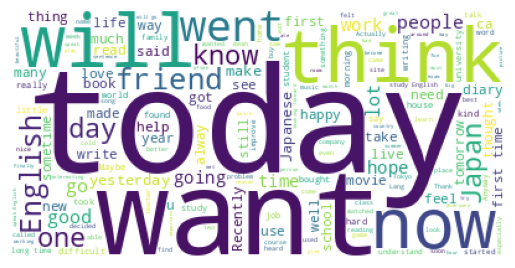

In [40]:
text = " ".join(final_data['correct'])

WC = WordCloud(background_color="white").generate(text)

plt.imshow(WC)
plt.axis("off")
plt.show()

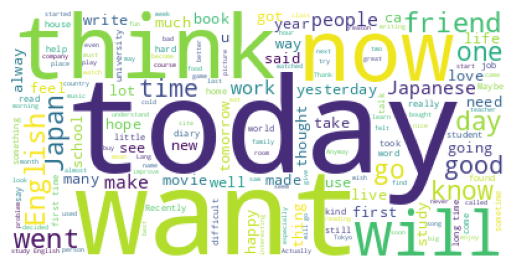

In [41]:
text = " ".join(final_data['error'])

WC = WordCloud(background_color="white").generate(text)

plt.imshow(WC)
plt.axis("off")
plt.show()

In [42]:
len_1 = [ len(final_data['correct'].iloc[i]) for i in range(len(final_data['correct'])) ]
len_2= [ len(final_data['error'].iloc[i]) for i in range(len(final_data['error'])) ]


Text(0.5, 0, 'Number of words in the grammatically correct sentences')

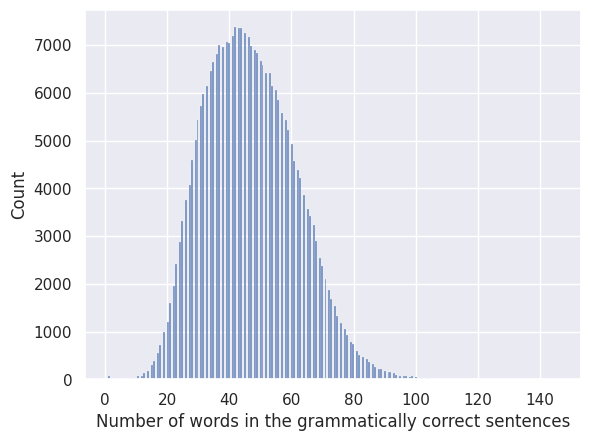

In [43]:
sns.set_theme()
ax = sns.histplot(data=len_1)
ax.set_xlabel('Number of words in the grammatically correct sentences')

Text(0.5, 0, 'Number of words in the grammatically incorrect sentences')

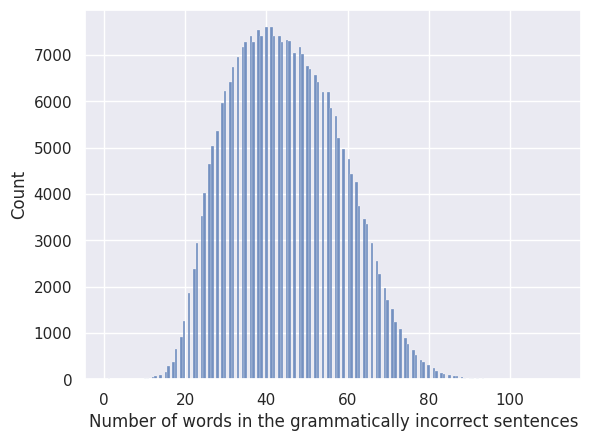

In [44]:
sns.set_theme()
ax = sns.histplot(data=len_2)
ax.set_xlabel('Number of words in the grammatically incorrect sentences')

In [45]:
for i in range(0, 100, 10):
  print(np.percentile(len_1,i))

1.0
28.0
34.0
38.0
42.0
46.0
50.0
54.0
60.0
67.0


In [46]:
for i in range(0, 100, 10):
  print(np.percentile(len_2,i))

1.0
28.0
32.0
36.0
40.0
44.0
48.0
52.0
57.0
63.0


- Base Line ENCODER-DECODER Model

In [47]:
#Import Necessary Libraries

In [ ]:
# TensorFlow should be installed via requirements.txt
# Run in terminal: pip install tensorflow
# 
# For GPU support, ensure you have:
# - CUDA Toolkit installed (compatible version for your TensorFlow)
# - cuDNN installed
# 
# Verify GPU is available:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 930.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.0 MB/s eta 0:00:00


In [49]:
import re
import datetime
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import keras
import tensorflow as tf
from sklearn.metrics import fbeta_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from tensorflow.keras.layers import Embedding,LSTM, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.initializers import HeNormal, GlorotNormal, GlorotUniform
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
data = pd.read_csv(os.path.join(DATA_DIR, 'final_preprocessed_15.csv'))

Since preprocessing of data is already done before, all we do is add the tokens required to feed the data into our Encoder Decoder model with attention.

We implement the teacher forcing approach such that the the data looks like this:

1. Encoder input:
<start> Hello how are youz ? <end>
2. Decoder input:
<start> Hello how are you ?
3. Decoder output:
Hello how are you? <end>

- This allows the decoder to always stay one step ahead during learning.

In [51]:
def preprocess(t, add_start_token, add_end_token):

  if add_start_token == True and add_end_token == False:
    t = '<start>'+' '+t
  if add_start_token == False and add_end_token == True:
    t = t+' '+'<end>'
  if add_start_token == True and add_end_token == True:
    t = '<start>'+' '+t+' '+'<end>'

  t = re.sub(' +', ' ', t)
  return t

In [52]:
encoder_input = [preprocess(line, add_start_token= True, add_end_token=True) for line in data['error']]
decoder_input = [preprocess(line, add_start_token= True, add_end_token=False) for line in data['correct']]
decoder_output = [preprocess(line, add_start_token= False, add_end_token=True) for line in data['correct']]

In [53]:
print(encoder_input[0])
print(decoder_input[0])
print(decoder_output[0])

<start> And he took in my favorite subject like soccer . <end>
<start> And he took in my favorite subjects like soccer .
And he took in my favorite subjects like soccer . <end>


In [54]:
#ENCODER INPUT

tokenizer = Tokenizer(filters='', split=" ")
tokenizer.fit_on_texts(encoder_input)
word_index = tokenizer.word_index #vocabulary

max_length = max([ len(row.split(" ")) for row in encoder_input ])
INPUT_ENCODER_LENGTH = max_length

enc_input_encoded = tokenizer.texts_to_sequences(encoder_input)
enc_input_padded= pad_sequences(enc_input_encoded, maxlen=INPUT_ENCODER_LENGTH, padding="post")

print(enc_input_padded.shape)

(288057, 17)


In [55]:
print(encoder_input[0])
print(enc_input_padded[0])

<start> And he took in my favorite subject like soccer . <end>
[  1  11  46 177  13  10 280 901  39 615   3   2   0   0   0   0   0]


In [56]:
#DECODER INPUT
decoder_data = decoder_input.copy()
decoder_data.extend(decoder_output)

out_tokenizer = Tokenizer(filters='', split=" ")
out_tokenizer.fit_on_texts(decoder_data)
word_index = out_tokenizer.word_index #vocabulary

max_length = max([ len(row.split(" ")) for row in decoder_input ])
INPUT_DECODER_LENGTH = max_length

In [57]:
dec_input_encoded = out_tokenizer.texts_to_sequences(decoder_input)
dec_input_padded= pad_sequences(dec_input_encoded, maxlen=INPUT_DECODER_LENGTH, padding="post", truncating = "post")

print(dec_input_padded.shape)

(288057, 29)


In [58]:
print(decoder_input[0])
print(dec_input_padded[0])

<start> And he took in my favorite subjects like soccer .
[   3   12   46  178   13   10  266 1499   41  608    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [59]:
dec_output_encoded = out_tokenizer.texts_to_sequences(decoder_output)
dec_output_padded= pad_sequences(dec_output_encoded, maxlen=INPUT_DECODER_LENGTH, padding="post", truncating = "post")

print(dec_output_padded.shape)

(288057, 29)


In [60]:
print(decoder_output[1])
print(dec_output_padded[1])

Actually , he was the one who let me know about Lang - . . <end>
[269   6  46  17   5  60 106 316  26  74  37 169  44   1   1   4   0   0
   0   0   0   0   0   0   0   0   0   0   0]


FASTTEXT EMBEDDINGS

In [ ]:
# IMPORT THE FASTTEXT EMBEDDINGS
# Download FastText embeddings if not present

import urllib.request
import zipfile

FASTTEXT_URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
FASTTEXT_ZIP = os.path.join(EMBEDDINGS_DIR, "wiki-news-300d-1M.vec.zip")
FASTTEXT_VEC = os.path.join(EMBEDDINGS_DIR, "wiki-news-300d-1M.vec")

if os.path.exists(FASTTEXT_VEC):
    print("FastText embeddings already downloaded and extracted!")
elif os.path.exists(FASTTEXT_ZIP):
    print("ZIP file exists, skipping download...")
else:
    print("Downloading FastText embeddings (~650MB)... This may take a few minutes.")
    
    def download_progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(100, downloaded * 100 / total_size)
        print(f"\rProgress: {percent:.1f}% ({downloaded / 1024 / 1024:.1f} MB / {total_size / 1024 / 1024:.1f} MB)", end="")
    
    urllib.request.urlretrieve(FASTTEXT_URL, FASTTEXT_ZIP, download_progress)
    print("\nDownload complete!")

--2026-01-19 04:25:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  76.3MB/s    in 8.3s    

2026-01-19 04:25:48 (78.6 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
# Extract FastText embeddings
if os.path.exists(FASTTEXT_VEC):
    print("FastText embeddings already extracted!")
else:
    print("Extracting FastText embeddings...")
    with zipfile.ZipFile(FASTTEXT_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EMBEDDINGS_DIR)
    print("Extraction complete!")
    
# Verify file exists
print(f"FastText file location: {FASTTEXT_VEC}")
print(f"File exists: {os.path.exists(FASTTEXT_VEC)}")

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [63]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:])#map(float, tokens[1:])
    return data

In [ ]:
embedding_index = load_vectors(FASTTEXT_VEC)

In [ ]:
word_index = tokenizer.word_index
num_tokens = len(word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)

    if type(embedding_vector) == np.ndarray and embedding_vector.shape[0] == 300:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))
np.save(os.path.join(EMBEDDINGS_DIR, 'in_embedding.npy'), embedding_matrix)

Converted 31916 words (20466 misses)


In [ ]:
word_index = out_tokenizer.word_index
num_tokens = len(word_index) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)

    if type(embedding_vector) == np.ndarray and embedding_vector.shape[0] == 300:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))
np.save(os.path.join(EMBEDDINGS_DIR, 'out_embedding.npy'), embedding_matrix)

Converted 28634 words (12426 misses)


VANILLA ENCODER DECODER

In [ ]:
in_embedding_matrix = np.load(os.path.join(EMBEDDINGS_DIR, 'in_embedding.npy'))
out_embedding_matrix = np.load(os.path.join(EMBEDDINGS_DIR, 'out_embedding.npy'))
print(in_embedding_matrix.shape, out_embedding_matrix.shape)

(52384, 300) (41062, 300)


In [68]:
#ENCODER
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_units = lstm_size
        self.input_length = input_length


    def build(self, input_sequence):
        #self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
        #                           #embeddings_initializer=keras.initializers.Constant(in_embedding_matrix), mask_zero=True,
        #                           weights = [in_embedding_matrix], mask_zero=True,
        #                           trainable = False, name="embedding_layer_encoder")
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence,states, training = True):
        input_embedding = self.embedding(input_sequence)   #(batch_size, length of input array, embedding_size)
        self.lstm_output, self.state_h, self.state_c = self.lstm(input_embedding, initial_state = states)
        return self.lstm_output,self.state_h, self.state_c


    def initialize_states(self,batch_size):
      initializer = GlorotNormal()
      lstm_state_h = initializer(shape=(batch_size, self.lstm_units))#tf.zeros((batch_size, self.lstm_units), dtype=tf.dtypes.float32, name="Encoder_LSTM_hidden_state")
      lstm_state_c = initializer(shape=(batch_size, self.lstm_units))#tf.zeros((batch_size, self.lstm_units), dtype=tf.dtypes.float32, name="Encoder_LSTM_cell_state")
      return lstm_state_h, lstm_state_c

#DECODER
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_units = lstm_size
        self.input_length = input_length


    def build(self,input_sequence):
        #self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
        #                           #embeddings_initializer=keras.initializers.Constant(out_embedding_matrix),
        #                           weights = [out_embedding_matrix], mask_zero=True,
        #                           trainable = False, name="embedding_layer_decoder")
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, name="Decoder_LSTM")


    def call(self,input_sequence,initial_states, training = True):

        input_embedding = self.embedding(input_sequence)
        self.lstm_output, self.state_h, self.state_c = self.lstm(input_embedding, initial_state=initial_states)
        return self.lstm_output,self.state_h, self.state_c

In [69]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size):

        super().__init__()
        self.encoder = Encoder(INPUT_VOCAB_SIZE, embedding_size = 256, lstm_size= 1200 , input_length= INPUT_ENCODER_LENGTH)
        self.decoder = Decoder(OUTPUT_VOCAB_SIZE, embedding_size = 256, lstm_size = 1200, input_length = None)
        self.dense = Dense(output_vocab_size)#, activation = 'softmax')

    def call(self,data):
        input, output = data[0], data[1]
        states = self.encoder.initialize_states(input.shape[0])
        encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input, states)
        decoder_output,decoder_state_h,decoder_state_c = self.decoder(output,[encoder_final_state_h,encoder_final_state_c])
        outputs = self.dense(decoder_output)

        return outputs

In [70]:
INPUT_VOCAB_SIZE = len(list(tokenizer.word_index)) +1 #for zero padding +OOV
OUTPUT_VOCAB_SIZE = len(list(out_tokenizer.word_index)) +1 #for zero padding + OOV
BATCH_SIZE = 16
print(INPUT_VOCAB_SIZE, INPUT_ENCODER_LENGTH, OUTPUT_VOCAB_SIZE, INPUT_DECODER_LENGTH, BATCH_SIZE)

52383 17 41061 29 16



Prepare data for feeding to model

In [71]:
NUMBER_OF_DATAPOINTS = 10000

tf.random.set_seed(32)

encoder_input_datatset = tf.data.Dataset.from_tensor_slices(enc_input_padded)
decoder_input_datatset = tf.data.Dataset.from_tensor_slices(dec_input_padded)
decoder_output_datatset = tf.data.Dataset.from_tensor_slices(dec_output_padded)

full_dataset =  tf.data.Dataset.zip( ((encoder_input_datatset.take(NUMBER_OF_DATAPOINTS), decoder_input_datatset.take(NUMBER_OF_DATAPOINTS)), decoder_output_datatset.take(NUMBER_OF_DATAPOINTS) ) ).shuffle(1000) #encoder_input_datatset.take(NUMBER_OF_DATAPOINTS).repeat(2)


In [72]:
test_dataset = full_dataset.take(50).batch(32)
train_dataset = full_dataset.skip(50).batch(32)

print(train_dataset, test_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 17), dtype=tf.int32, name=None), TensorSpec(shape=(None, 29), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 29), dtype=tf.int32, name=None))> <_BatchDataset element_spec=((TensorSpec(shape=(None, 17), dtype=tf.int32, name=None), TensorSpec(shape=(None, 29), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 29), dtype=tf.int32, name=None))>


In [ ]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# EARLY STOPPING
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# TENSORBOARD PLOTS - save logs to models directory
LOGS_DIR = os.path.join(MODELS_DIR, 'logs')
os.makedirs(LOGS_DIR, exist_ok=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=LOGS_DIR)

# SAVE MODEL WEIGHTS
class SaveModel(tf.keras.callbacks.Callback):

    def __init__(self):
        self.history = {'loss': [], 'val_loss': []}
        self.init = 0

    def on_epoch_end(self, epoch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))

        # Save weights
        weights_path = os.path.join(ENC_DEC_EMB_DIR, f'weights_{epoch+self.init}.weights.h5')
        self.model.save_weights(weights_path)
        print(f'Saved weights to {weights_path}')

        # Save history
        df = pd.DataFrame(columns=['loss', 'val_loss'])
        for col in df.columns:
            df[col] = self.history[col]
        
        history_path = os.path.join(ENC_DEC_EMB_DIR, 'history.csv')
        df.to_csv(history_path, index=False)

save_model = SaveModel()

In [79]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [80]:
'''This code calculates the macro averaged fbeta score for each data point and outputs the mean of 32 scores'''

def f_beta_score(y_true, y_pred):
  y_pred_sparse = tf.convert_to_tensor(np.argmax(y_pred, axis = -1), dtype = tf.float32)
  fb_score = [ fbeta_score(y_true[i], y_pred_sparse[i],average = 'macro',beta = 0.5) for i in range(y_true.shape[0])]#tf.py_function(fbeta_score, inp = [y, y_pred, 0.5], Tout=tf.float32)
  return sum(fb_score)/len(fb_score)

In [81]:
tf.config.run_functions_eagerly(True)

#Create an object of encoder_decoder Model class,
# Compile the model and fit the model
input = np.random.randint(0, 64, size=(BATCH_SIZE, INPUT_ENCODER_LENGTH))
output = np.random.randint(0, 64, size=(BATCH_SIZE, INPUT_DECODER_LENGTH))
target = np.random.randint(0, 64, size=(BATCH_SIZE, INPUT_DECODER_LENGTH))#tf.keras.utils.to_categorical(output, OUTPUT_VOCAB_SIZE)

model = Encoder_decoder(encoder_inputs_length = INPUT_ENCODER_LENGTH, decoder_inputs_length =INPUT_DECODER_LENGTH, output_vocab_size= OUTPUT_VOCAB_SIZE)
#model = encoder_decoder(enc_units = 1024, dec_units = 1024, scoring_func = 'dot', att_units = 1024)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function, metrics = [f_beta_score])#tf.keras.metrics.categorical_crossentropy)
model.fit([input, output], target, steps_per_epoch=1)

model.summary()

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - f_beta_score: 0.0000e+00 - loss: 10.2336


Model: "encoder_decoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │    20,403,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │    17,505,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 29, 41061)        │    49,314,261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,669,377 (998.19 MB)

 Trainable params: 87,223,125 (332.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,446,252 (665.46 MB)

WITH FASTTEXT EMBEDDINGS

In [ ]:
# Create model weights directory (already created in setup, but ensure it exists)
os.makedirs(ENC_DEC_EMB_DIR, exist_ok=True)
print(f"Model weights will be saved to: {ENC_DEC_EMB_DIR}")

In [ ]:
#TEST1 1200 encoder decoder att units  #10000
model.fit(train_dataset,
          validation_data = test_dataset,
          epochs = 50,
          callbacks = [early_stopping,tensorboard_cb, save_model])

Epoch 1/50
136/311 ━━━━━━━━━━━━━━━━━━━━ 23:13 8s/step - f_beta_score: 0.1245 - loss: 1.8310

WITHOUT FASTTEXT EMBEDDINGS

In [ ]:
#TEST1 1200 encoder decoder att units  #1000
model.fit(train_dataset,
          validation_data = test_dataset,
          epochs = 50,
          callbacks = [early_stopping,tensorboard_cb, save_model])

In [ ]:
# Load pre-trained weights (update filename as needed based on your best checkpoint)
best_weights_path = os.path.join(ENC_DEC_EMB_DIR, 'weights_24_best.h5')
if os.path.exists(best_weights_path):
    model.load_weights(best_weights_path)
    print(f"Loaded weights from {best_weights_path}")
else:
    print(f"Warning: Weights file not found at {best_weights_path}")
    print("Available weight files:")
    for f in os.listdir(ENC_DEC_EMB_DIR):
        if f.endswith('.h5') or f.endswith('.weights.h5'):
            print(f"  - {f}")

In [ ]:
#Input processor
def input_processor(input_sentence, pad_seq):

  #Preprocess to remove unwanted characters and convert to ASCII characters
  encoder_input = preprocess(input_sentence, add_start_token= True, add_end_token=True)

  #Convert to sequence
  tokenized_text = tokenizer.texts_to_sequences([encoder_input])
  if pad_seq == True:
    tokenized_text = pad_sequences(tokenized_text, maxlen=INPUT_ENCODER_LENGTH, padding="post")

  tokenized_text = tf.convert_to_tensor(tokenized_text, dtype = tf.float32)
  return tokenized_text


def remove_end_token(words):
  words_list = words.split(' ')[:-1]
  words = " ".join(words_list)
  return words

In [ ]:
def predict(input_sentence):
  input = input_processor(input_sentence, pad_seq = False)

  INPUT_LENGTH = input.shape[0] #Or number of inputs

  states = model.layers[0].initialize_states(INPUT_LENGTH)

  encoder_output,encoder_final_state_h,encoder_final_state_c = model.layers[0](input, states)
  states = [encoder_final_state_h,encoder_final_state_c]  #States to initialize Decoder with

  input_decoder = np.zeros((1,1))
  input_decoder[0][0] = 2  #<start> for eng vocab

  decoder_output_list = []
  stop = False

  while stop != True :

    decoder_output, dec_final_state_h, dec_final_state_c = model.layers[1](input_decoder, states)

    states = [dec_final_state_h, dec_final_state_c]

    output = model.layers[2](decoder_output)

    index = np.argmax(output, -1)
    decoder_output_list.append(index)
    input_decoder = index

    if index[0][0] == 4 :#or len(decoder_output_list) > input.shape[1]: #Index of <end> for out_tokenizer
      stop =True

  #Get the output tokens and store in arr_out
  arr_out = [int(np.asarray(i)[0][0]) for i in decoder_output_list]

  #Convert to text
  output_words = out_tokenizer.sequences_to_texts([arr_out])

  return output_words

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Pick 1000 random indices
indices = [random.randint(0, 10000) for i in range(1000)]
sent_list = [data['error'].iloc[i] for i in indices]
bleu_scores_ = []
actual_output = []
output_sent_list = []

print(sent_list)

#Translate and calculate BLEU scores
for i, sent in enumerate(tqdm(sent_list)):
  out = predict(sent)
  actual_ = decoder_output[indices[i]]

  output_sent_list.append(out[0])
  actual_output.append(actual_)

  #Remove <end> token
  out_words = remove_end_token(out[0])
  actual_output_ = remove_end_token(actual_)

  #Calculate BLEU scores
  bleu_scores_.append(sentence_bleu(actual_output_.split(' '), out_words.split(' ')))


print('Average BLEU score :',sum(bleu_scores_)/len(bleu_scores_))

In [ ]:
df = pd.DataFrame(columns= ['input_sentence', 'actual_output','translated_output', 'bleu_score'])
df['input_sentence'] = sent_list
df['actual_output'] = actual_output
df['translated_output'] = output_sent_list
df['bleu_score'] = bleu_scores_

Without FastText embeddings (for comparison)

In [ ]:
# Load weights for comparison (without FastText embeddings model)
# Update path to where you have saved this model locally
comparison_weights_path = os.path.join(MODELS_DIR, 'ENC_DEC', 'weights_49_.h5')
if os.path.exists(comparison_weights_path):
    model.load_weights(comparison_weights_path)
    print(f"Loaded weights from {comparison_weights_path}")
else:
    print(f"Warning: Weights file not found at {comparison_weights_path}")
    print("If you have this file from Google Drive, place it in:")
    print(f"  {os.path.join(MODELS_DIR, 'ENC_DEC')}")

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Pick 1000 random indices
indices = [random.randint(0, 10000) for i in range(1000)]
sent_list = [data['error'].iloc[i] for i in indices]
bleu_scores_ = []
actual_output = []
output_sent_list = []

print(sent_list)

#Translate and calculate BLEU scores
for i, sent in enumerate(tqdm(sent_list)):
  out = predict(sent)
  actual_ = decoder_output[indices[i]]

  output_sent_list.append(out[0])
  actual_output.append(actual_)

  #Remove <end> token
  out_words = remove_end_token(out[0])
  actual_output_ = remove_end_token(actual_)

  #Calculate BLEU scores
  bleu_scores_.append(sentence_bleu(actual_output_.split(' '), out_words.split(' ')))


print('Average BLEU score :',sum(bleu_scores_)/len(bleu_scores_))

In [ ]:
df = pd.DataFrame(columns= ['input_sentence', 'actual_output','translated_output', 'bleu_score'])
df['input_sentence'] = sent_list
df['actual_output'] = actual_output
df['translated_output'] = output_sent_list
df['bleu_score'] = bleu_scores_